In [23]:
%load_ext lab_black

In [31]:
import sys

sys.path.append("..")
from gpblocks import Prior, RBF, Gaussian, ZeroMean
import jax
import jax.numpy as jnp
import jax.random as jr
import objax
import numpy as onp
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)

Simulate some data

In [124]:
N = 50
noise = 0.5

X = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,))
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(X)
y = signal + jr.normal(key, shape=signal.shape) * noise
Xtest = jnp.linspace(-3.5, 3.5, 500)
ytest = f(Xtest)

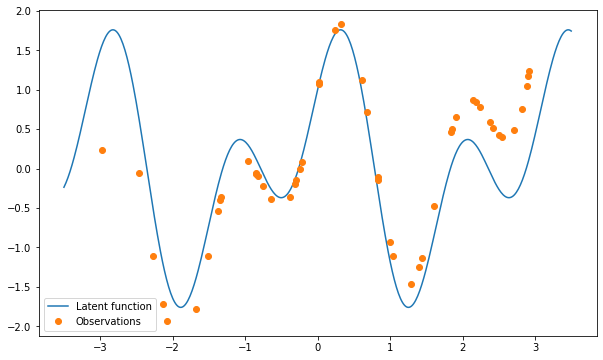

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Xtest, ytest, label="Latent function")
ax.plot(X, y, "o", label="Observations")
ax.legend(loc="best")

# Define GP prior

In [137]:
kernel = RBF()
meanf = ZeroMean()

prior = Prior(kernel=RBF(), mean_function=meanf, jitter=1e-6)

Add some prior sampling code here.

In [138]:
posterior = prior * Gaussian()

# Optimise the posterior

The likelihood here is Gaussian, therefore we are able to analytically integrate out the latent function from our posterior. Because of this, all that is left to do is optimise the GP's hyperparameters $\mathbf{\theta}$ which, for this kernel type, comprises of a kernel lengthscale and variance parameter, along with an observation noise term.

To proceed, we first define an objective function for which an optimiser can minimise.

In [139]:
def loss(X, label):
    distr = posterior.forward(X)
    return -distr.log_prob(label).mean()

We can now define an optimiser. Fortunately, `objax` supplies several optimisers from which we'll select a stochastic gradient descent optimiser.

In [140]:
opt = objax.optimizer.SGD(posterior.vars())

For the optimiser to work, gradients are required. Using the automatic differentiation that is built into Jax, we can then define the gradient of our loss term with respect to $\theta$.

In [141]:
gv = objax.GradValues(loss, posterior.vars())

Let's wrap this up now into a optimisation step. This may seem superfluous, but doing so will allow us to them compile the function. Long-term, a compiled function will operate more efficiently than a regular function. 

In [142]:
def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())

Everything is now in place to begin optimise the GP's hyperparameters.

In [143]:
nits = 50
loss = [train_op(X, y.squeeze())[0].item() for _ in range(nits)]

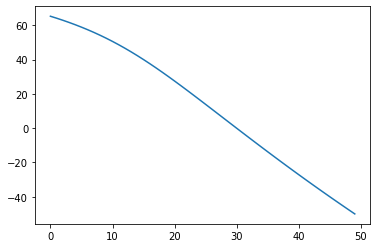

In [144]:
plt.plot(loss)

# Predict

We can now begin to make predictions at some unseen test points

In [145]:
mu, cov = posterior.predict(Xtest, X, y.squeeze())

Now let's visualise this 

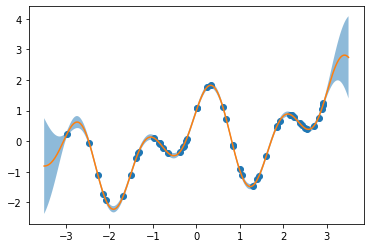

In [146]:
plt.plot(X, y, "o")
plt.plot(Xtest, mu)
plt.fill_between(
    Xtest.ravel(),
    mu.squeeze()
    - 1.96 * np.sqrt(np.diag(cov) + jax.nn.softplus(posterior.likelihood.noise.value)),
    mu.squeeze()
    + 1.96 * np.sqrt(np.diag(cov) + jax.nn.softplus(posterior.likelihood.noise.value)),
    alpha=0.5,
)
plt.show()

In [153]:
for k, v in posterior.vars().items():
    print(k, ": ", v.value)

(Posterior).kernel(RBF).lengthscale :  [0.06987821]
(Posterior).kernel(RBF).variance :  [1.1910542]
(Posterior).likelihood(Gaussian).noise :  [-6.58944]
